In [11]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
script_dir = os.getcwd()

from sde.sde_learning_network_modified import (
    TimingCallback,
    SDEIdentification,
    ModelBuilder,
    SDEApproximationNetwork,
)

from sde.experiment_reports import (
    sample_data,
    plot_results_functions,
    generate_results,
    plot_results_1d,
    histogram_data,
    plot_histogram
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# notebook parameters
random_seed = 1
step_size = 1e-2
n_pts = 10000

n_layers = 1
n_dim_per_layer = 2**8

n_dimensions = 2

#ACTIVATIONS = tf.nn.elu
def ACTIVATIONS(x):
    j = tf.constant(1j, dtype=tf.complex64)
    x = tf.cast(x, dtype=tf.complex64)
    return tf.exp(j * x)
VALIDATION_SPLIT = .1
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
N_EPOCHS = 100

# only diagonal diffusivity matrix
diffusivity_type = "diagonal"

tf.random.set_seed(random_seed)

In [13]:
# EXAMPLE 2

def true_potential(x):
    return (x**4-4*x**2+3*x)/2


def true_drift(x):
    return -(4*x**3 - 2*4*x+3)/2 # negative derivative of the potential, with additive parameter p


def true_diffusivity(x):
    return (1e-1*x+1)*0.5
    # return true_drift(x), true_diffusivity(x)


def true_drift_diffusivity(x, param=None):
    return true_drift(x), true_diffusivity(x)


rng = np.random.default_rng(random_seed)

xlim = [-2, 2]

x_data, y_data = sample_data(true_drift_diffusivity,
                             step_size=step_size, n_dimensions=n_dimensions,
                             low=xlim[0], high=xlim[1], n_pts=n_pts,
                             rng=rng)
x_data_test, y_data_test = sample_data(true_drift_diffusivity,
                                       step_size=step_size,
                                       n_dimensions=n_dimensions,
                                       low=xlim[0], high=xlim[1],
                                       n_pts=n_pts//10, rng=rng)
print('data shape', x_data.shape)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

data shape (10000, 2)


In [14]:
# train model
No_of_tests = 30
cumulative_times = np.zeros((No_of_tests, N_EPOCHS))
losses = np.zeros((No_of_tests, N_EPOCHS))
val_losses = np.zeros((No_of_tests, N_EPOCHS))
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    # define model
    tf.random.set_seed(i)
    encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="GP",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
    model = SDEApproximationNetwork(sde_model=encoder, method="euler")
    model.compile(optimizer=tf.keras.optimizers.Adamax())
    sde_i = SDEIdentification(model=model)
    timing_callback = TimingCallback()
    
    hist, _ = sde_i.train_model(x_data, y_data, step_size=step_sizes, validation_split=VALIDATION_SPLIT, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, callbacks=[timing_callback])
    
    cumulative_times[i,:] = timing_callback.epoch_times
    losses[i,:] = hist.history["loss"]
    val_losses[i,:] = hist.history["val_loss"]

    moving_avg = np.zeros(N_EPOCHS)
    min_moving_avg = float('inf')
    moving_avg_len = 5
    min_index = 0
    break_iterations = 5
    for j in range(N_EPOCHS):
        if j < moving_avg_len:
            moving_avg[j] = np.mean(val_losses[i,:j+1])
        else:
            moving_avg[j] = np.mean(val_losses[i,j-moving_avg_len+1:j+1])

        if moving_avg[j] < min_moving_avg:
            min_moving_avg = moving_avg[j]
            min_index = j

        if min_index + break_iterations < j:
            break

    val_loss_array = val_losses[i,:j]
    val_loss_min_index = np.argmin(val_loss_array)
    training_time[i] = cumulative_times[i,val_loss_min_index]
    val_loss[i] = val_losses[i,val_loss_min_index]


training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, v

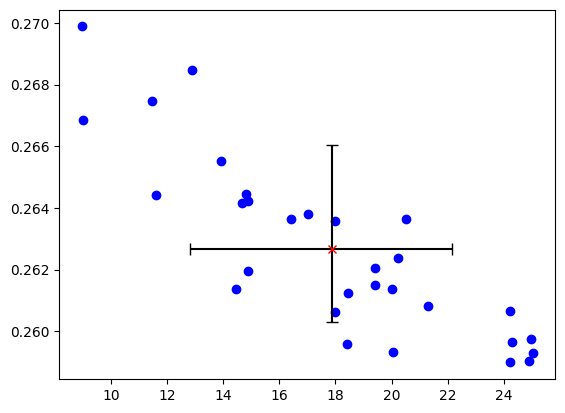

0.26265607177752487 17.873821608225505


In [15]:
# Calculate the mean
mean_training_time = np.mean(training_time)
mean_val_loss = np.mean(val_loss)

# Calculate the standard deviation above and below the mean for training_time
training_time_above = training_time[training_time > mean_training_time] - mean_training_time
training_time_below = mean_training_time - training_time[training_time < mean_training_time]

std_training_time_above = np.std(np.concatenate((training_time_above, -training_time_above)))
std_training_time_below = np.std(np.concatenate((training_time_below, -training_time_below)))

# Calculate points above and below the mean for val_loss
val_loss_above = val_loss[val_loss > mean_val_loss] - mean_val_loss
val_loss_below = mean_val_loss - val_loss[val_loss < mean_val_loss]

std_val_loss_above = np.std(np.concatenate((val_loss_above, -val_loss_above)))
std_val_loss_below = np.std(np.concatenate((val_loss_below, -val_loss_below)))

# Plot scatter points
plt.scatter(training_time, val_loss, color='blue', label='Data Points')

# Add non-symmetrical error bars (standard deviations)
plt.errorbar(
    mean_training_time, mean_val_loss,
    xerr=[[std_training_time_below], [std_training_time_above]],  # Non-symmetrical x error
    yerr=[[std_val_loss_below], [std_val_loss_above]],  # Non-symmetrical y error
    fmt='x', color='red', ecolor='black', elinewidth=1.5, capsize=4, label='Mean ± STD'
)
plt.show()

output_dir = os.path.join(script_dir, 'loss_data')
output_path = os.path.join(output_dir, "example3 - 2d sde-cubic data.txt")
with open(output_path, 'w') as file:
    file.write(f"{mean_training_time},{mean_val_loss},{std_training_time_above},{std_training_time_below},{std_val_loss_above},{std_val_loss_below}\n")

print(mean_val_loss, mean_training_time) 

In [16]:
encoder.summary()

Model: "GP_gaussian_process"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 GP_inputs (InputLayer)         [(None, 2)]          0           []                               
                                                                                                  
 GP_mean_hidden_0 (Dense)       (None, 256)          768         ['GP_inputs[0][0]']              
                                                                                                  
 GP_std_hidden_0 (Dense)        (None, 256)          768         ['GP_inputs[0][0]']              
                                                                                                  
 GP_output_mean (Dense)         (None, 2)            514         ['GP_mean_hidden_0[0][0]']       
                                                                                

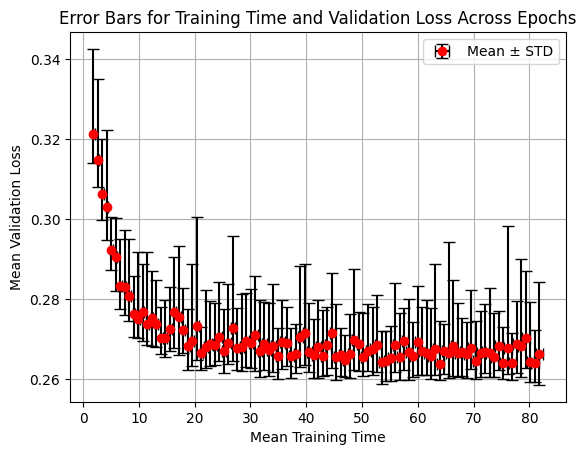

In [17]:
# Initialize arrays to store results
mean_training_time = np.zeros(N_EPOCHS)
mean_val_loss = np.zeros(N_EPOCHS)
std_training_time_above = np.zeros(N_EPOCHS)
std_training_time_below = np.zeros(N_EPOCHS)
std_val_loss_above = np.zeros(N_EPOCHS)
std_val_loss_below = np.zeros(N_EPOCHS)

# Iterate over epochs
for epoch in range(N_EPOCHS):
    training_time = cumulative_times[:, epoch]
    val_loss = val_losses[:, epoch]

    # Calculate mean
    mean_training_time[epoch] = np.mean(training_time)
    mean_val_loss[epoch] = np.mean(val_loss)

    # Calculate deviations for training_time
    training_time_above = training_time[training_time > mean_training_time[epoch]] - mean_training_time[epoch]
    training_time_below = mean_training_time[epoch] - training_time[training_time < mean_training_time[epoch]]
    std_training_time_above[epoch] = np.std(np.concatenate((training_time_above, -training_time_above)))
    std_training_time_below[epoch] = np.std(np.concatenate((training_time_below, -training_time_below)))

    # Calculate deviations for val_loss
    val_loss_above = val_loss[val_loss > mean_val_loss[epoch]] - mean_val_loss[epoch]
    val_loss_below = mean_val_loss[epoch] - val_loss[val_loss < mean_val_loss[epoch]]
    std_val_loss_above[epoch] = np.std(np.concatenate((val_loss_above, -val_loss_above)))
    std_val_loss_below[epoch] = np.std(np.concatenate((val_loss_below, -val_loss_below)))

plt.errorbar(
    mean_training_time, mean_val_loss,
    xerr=[std_training_time_below, std_training_time_above],  # Non-symmetrical x error
    yerr=[std_val_loss_below, std_val_loss_above],  # Non-symmetrical y error
    fmt='o', color='red', ecolor='black', elinewidth=1.5, capsize=4, label='Mean ± STD'
)

plt.xlabel('Mean Training Time')
plt.ylabel('Mean Validation Loss')
plt.title('Error Bars for Training Time and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)

In [18]:
# export data
data = pd.DataFrame({
    "cum_time": mean_training_time,
    "loss": mean_val_loss,
    "std_training_time_above": std_training_time_above,
    "std_training_time_below": std_training_time_below,
    "std_val_loss_above": std_val_loss_above,
    "std_val_loss_below": std_val_loss_below
})

# output_dir = os.path.join(script_dir, 'loss_data')
# output_path = os.path.join(output_dir, "example3 - 2d sde-cubic data.csv")
# data.to_csv(output_path, index=False)

figures_per_row 2


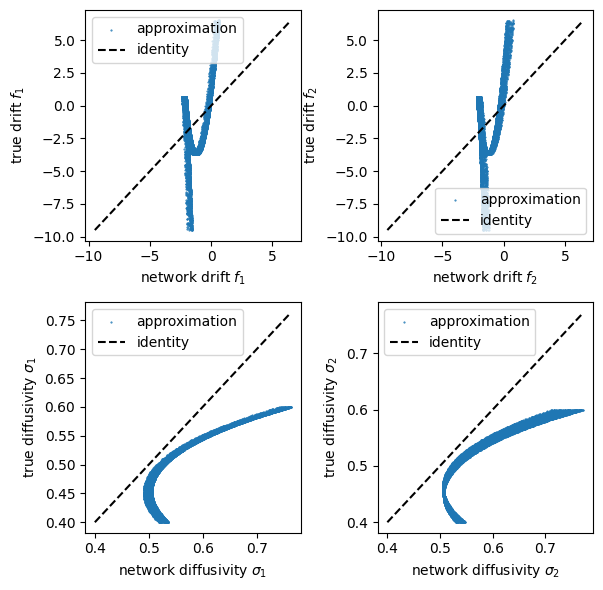

In [19]:
rng = np.random.default_rng(random_seed)

fig, ax = plot_results_functions(sde_i.drift_diffusivity, true_drift_diffusivity,
                            x_data, None, None,
                            data_transform_network=None,
                            data_transform_true=None)

# output_dir = os.path.join(script_dir, 'trained_vs_true_plots')
# output_path = os.path.join(output_dir, "example3 - 2d sde-cubic")
# plt.savefig(output_path, dpi=300, bbox_inches='tight')

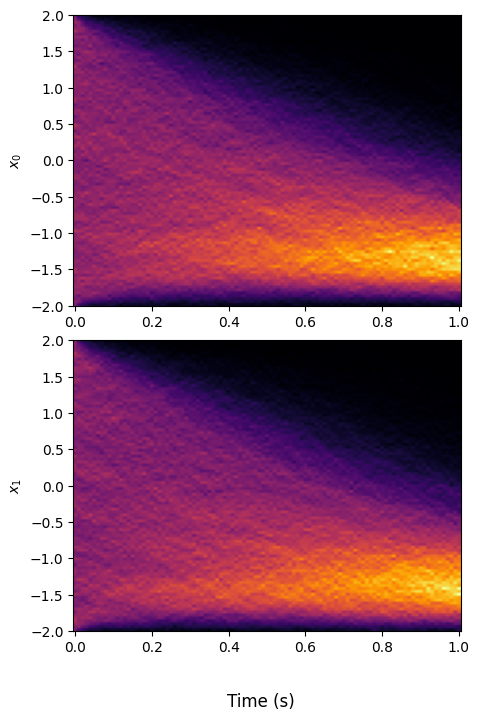

In [20]:
time = 100*step_size
SGD_paths = histogram_data(sde_i.drift_diffusivity, xlim[0], xlim[1], step_size, time, n_dimensions, random_seed, non_square_diff=True)

plot_histogram(SGD_paths, xlim[0], xlim[1], step_size)

# output_dir = os.path.join(script_dir, 'histogram_data')
# output_path_true = os.path.join(output_dir, "ex3 - 2d sde-cubic SGD.npy")
# np.save(output_path_true, SGD_paths)

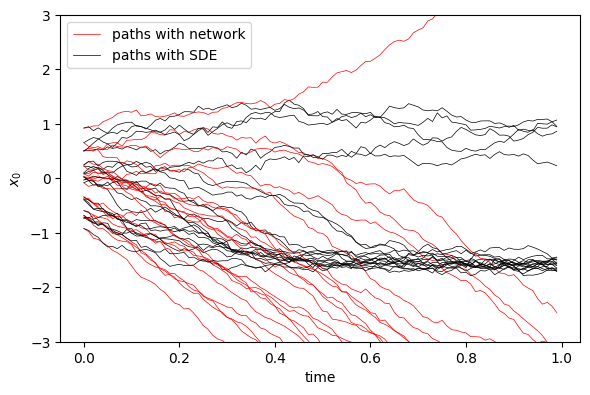

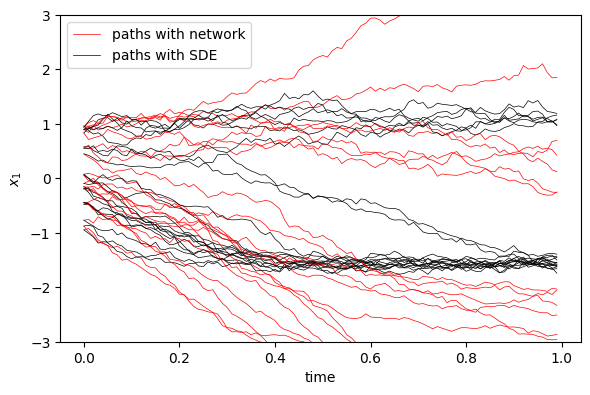

In [181]:
T_steps = 100
N_iterates = 20

rng = np.random.default_rng(random_seed)

time_steps, paths_network = \
    generate_results(sde_i.drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);
time_steps, paths_true = \
    generate_results(true_drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);

plot_results_1d(time_steps, paths_network, paths_true, plot_dim=0, linewidth=.5);
plt.gca().set_ylim([-3,3])
plt.gca().set_ylabel(r"$x_0$");
# plt.savefig(r"C:\Users\owen\Documents\jobs\KAUST\work\SDE AM project\project write up\saved plots\example3 - 2d paths.png")
plot_results_1d(time_steps, paths_network, paths_true, plot_dim=1, linewidth=.5);
plt.gca().set_ylim([-3,3])
plt.gca().set_ylabel(r"$x_1$");
# plt.savefig(r"C:\Users\owen\Documents\jobs\KAUST\work\SDE AM project\project write up\saved plots\example3 - 2d paths2.png")